In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as SS
import torch
from torchinfo import summary
from torch import nn
import pickle
import random
import copy
from sklearn.metrics import confusion_matrix

In [2]:
def seed_everything(seed=1234, is_cuda=False):
    """Some configurations for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if is_cuda:
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = True
        # torch.cuda.manual_seed(args.seed)
        torch.cuda.manual_seed_all(seed)

In [3]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

IID data distributuion

In [4]:
seed_everything(1234, True)
data = pd.read_csv("D:\PyCharmProject\polyuSubject\COMP5434\data.csv")
x = data.iloc[:,:-1].values
y = data['label'].values

# scaler
scaler = SS()
x = scaler.fit_transform(x)
pickle.dump(scaler, open('scaler.pkl','wb'))

X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state=1, test_size=0.2, stratify=y)
X_left, X_user1, Y_left, Y_user1 = train_test_split(X_train, Y_train, test_size=1/4, random_state=1, stratify=Y_train)
X_left, X_user2, Y_left, Y_user2 = train_test_split(X_left, Y_left, test_size=1/3, random_state=1, stratify=Y_left)
X_user4, X_user3, Y_user4, Y_user3 = train_test_split(X_left, Y_left, test_size=1/2, random_state=0, stratify=Y_left)

x0_train = X_user1
y0_train = Y_user1
x1_train = X_user2
y1_train = Y_user2
x2_train = X_user3
y2_train = Y_user3
x3_train = X_user4
y3_train = Y_user4
print(x0_train.shape, y0_train.shape, x1_train.shape, y1_train.shape, x2_train.shape, y2_train.shape, x3_train.shape, y3_train.shape)

(800, 50) (800,) (800, 50) (800,) (800, 50) (800,) (800, 50) (800,)


Same network settings with question 2.

In [5]:
seed_everything(1234, True)
class ANN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(50, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128, 256),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),

            nn.Linear(128, 4),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.model(x)
        return x

net = ANN()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
loss_func = torch.nn.CrossEntropyLoss()
batch_size = 128
summary(net)

Layer (type:depth-idx)                   Param #
ANN                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       6,528
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       33,024
│    └─Dropout: 2-4                      --
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       65,792
│    └─Dropout: 2-7                      --
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       32,896
│    └─Dropout: 2-10                     --
│    └─ReLU: 2-11                        --
│    └─Linear: 2-12                      516
│    └─ReLU: 2-13                        --
Total params: 138,756
Trainable params: 138,756
Non-trainable params: 0

FL is completed by four client networks, all of whom inherit the structure of the ANN() class.

get_client_grad() method is the core point for federated learning, which supports gradient calculations and parameter updates for each client based on the data they have been assigned. 

Since the update of the server networks is based on the mean of the four client networks parameters. Therefore during the calculation of each client we create a dictionary to store the parameters.

In [6]:
seed_everything(1234, True)
c0_net = ANN()
c1_net = ANN()
c2_net = ANN()
c3_net = ANN()

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def get_client_grad(client_inputs, client_labels, net_dict ,client_net):
    client_net.load_state_dict(net_dict)
    client_outputs = client_net(client_inputs)
    client_loss = loss_func(client_outputs, client_labels)
    client_optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    client_optimizer.zero_grad()
    client_loss.backward()

    # 提取梯度
    client_grad_dict = dict()  # name: params_grad
    params_modules = list(client_net.named_parameters())
    for params_module in params_modules:
        (name, params) = params_module
        params_grad = copy.deepcopy(params.grad)
        client_grad_dict[name] = params_grad
    client_optimizer.zero_grad()
    return client_grad_dict

The training of FL is also based on the Mini-batch, the difference is that instead of training one server network in a batch of data, we need to train four different client networks.

After a batch of data has been trained and all four networks have updated their parameters, the parameter values stored in the client_average_grad_dict will be averaged and assigned to the server.

In [7]:
seed_everything(seed=0, is_cuda=True)
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
plot_train_acc = []
plot_test_acc = []
plot_train_loss = []
plot_test_loss = []
best_acc = 0
weight_epoch = []
for epoch in range(200):
    weight_record = {}
    net.train()
    for start in range(0, len(x0_train), batch_size):
        end = start + batch_size if start + batch_size < len(x0_train) else len(x0_train)
        # client1
        c0x = torch.tensor(x0_train[start:end], dtype=torch.float, requires_grad=True)
        c0y = torch.tensor(y0_train[start:end], dtype=torch.long, requires_grad=False)
        net_dict = net.state_dict()
        client_0_grad_dict = get_client_grad(c0x, c0y, net_dict, c0_net)
        # client2
        c1x = torch.tensor(x1_train[start:end], dtype=torch.float, requires_grad=True)
        c1y = torch.tensor(y1_train[start:end], dtype=torch.long, requires_grad=False)
        net_dict = net.state_dict()
        client_1_grad_dict = get_client_grad(c1x, c1y, net_dict, c1_net)
        # client3
        c2x = torch.tensor(x2_train[start:end], dtype=torch.float, requires_grad=True)
        c2y = torch.tensor(y2_train[start:end], dtype=torch.long, requires_grad=False)
        net_dict = net.state_dict()
        client_2_grad_dict = get_client_grad(c2x, c2y, net_dict, c2_net)
        # client4
        c3x = torch.tensor(x3_train[start:end], dtype=torch.float, requires_grad=True)
        c3y = torch.tensor(y3_train[start:end], dtype=torch.long, requires_grad=False)
        net_dict = net.state_dict()
        client_3_grad_dict = get_client_grad(c3x, c3y, net_dict, c3_net)
        
        client_average_grad_dict = dict()
        for key in client_0_grad_dict:
            client_average_grad_dict[key] = (client_0_grad_dict[key] + client_1_grad_dict[key] + client_2_grad_dict[key] + client_3_grad_dict[key]) / 4
        
        params_modules_server = net.named_parameters()
        for params_module in params_modules_server:
            (name, params) = params_module
            params.grad = client_average_grad_dict[name]  # 用字典中存储的子模型的梯度覆盖server中的参数梯度
        optimizer.step()
        
        for name, param in net.named_parameters():
            if 'weight' in name:
                norm = torch.norm(param)
                weight_record[name] = norm
        weight_epoch.append(weight_record)

    net.eval()
    test_batch_loss = []
    test_all_acc1 = []
    
    with torch.no_grad():
        for start in range(0, len(X_test), batch_size):
            end = start + batch_size if start + batch_size < len(X_test) else len(X_test)
            single_test_xx = torch.tensor(X_test[start:end], dtype=torch.float, requires_grad=False)
            single_test_yy = torch.tensor(Y_test[start:end], dtype=torch.long, requires_grad=False)
            test_pred = net(single_test_xx)
            test_loss = loss_func(test_pred, single_test_yy)
            test_acc1, test_acc5 = accuracy(test_pred, single_test_yy, topk=(1, 1))
            test_all_acc1.append(test_acc1.cpu().item())
            test_batch_loss.append(test_loss.data.numpy())

    test_acc = max(test_all_acc1)
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(net.state_dict(), './best_model_3.pth')
        
    if epoch % 100 == 0:
        curr_lr = 0.0005
        update_lr(optimizer, curr_lr)

    test_loss_epoch = np.mean(test_batch_loss)

    plot_test_acc.append(test_acc)

    plot_test_loss.append(test_loss_epoch)
    if epoch % 10 == 0:
        print(epoch, test_acc, best_acc)


0 40.625 40.625
10 59.375 62.5
20 65.625 71.875
30 59.375 71.875
40 50.0 71.875
50 71.875 71.875
60 68.75 71.875
70 71.875 75.0
80 71.875 75.0
90 65.625 75.0
100 65.625 75.0
110 64.0625 75.0
120 64.84375 75.0
130 63.28125 75.0
140 71.875 75.0
150 65.625 75.0
160 63.28125 75.0
170 63.28125 75.0
180 60.9375 75.0
190 65.625 75.0


The best test accuracy for the Federated learning is 75.

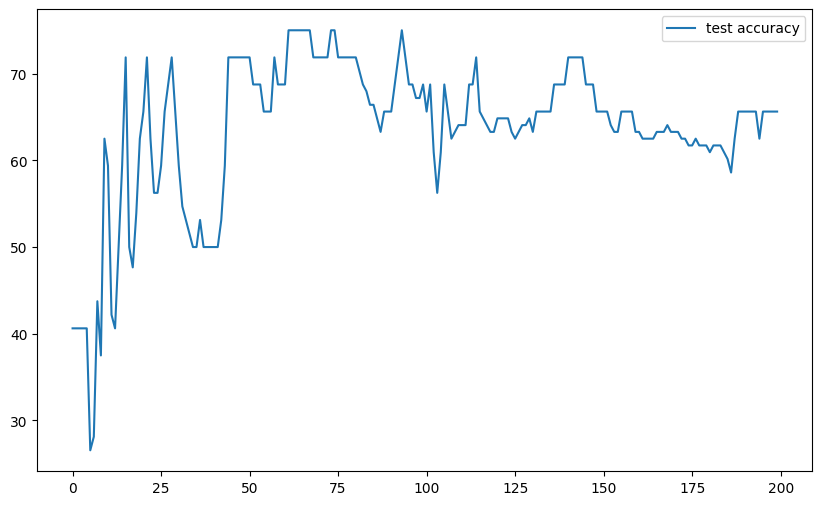

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 6])
plt.plot(range(0, 200), plot_test_acc)
plt.legend(['test accuracy'])
plt.show()

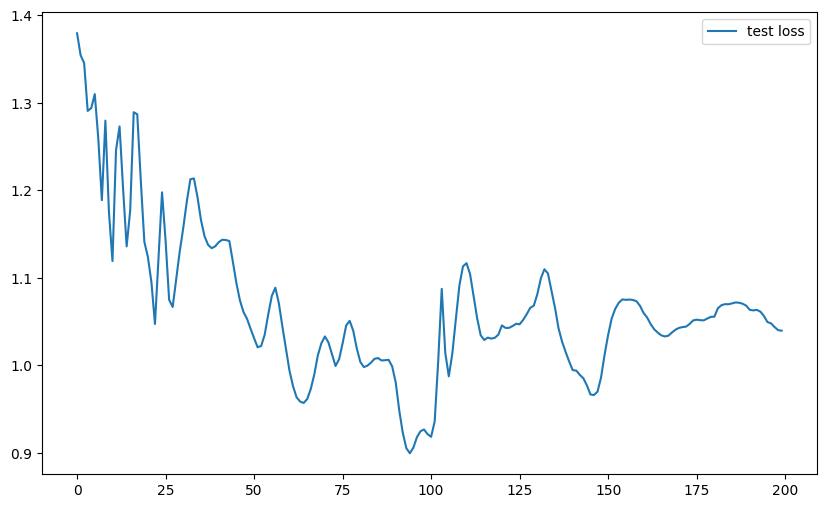

In [11]:
plt.figure(figsize=[10, 6])
plt.plot(range(0, 200), plot_test_loss)
plt.legend(['test loss'])
plt.show()

In [17]:
pd.DataFrame(np.array(res).reshape((-1,1))).to_csv("test_res_FL.csv")

By comparing the performance of the FL and ANN models, we found that the highest accuracy of the ANN was about five percent higher than that of the FL for the identical settings.
Also, observing the accuracy versus loss curves, FL has a more undulating curve compared to ANN. 

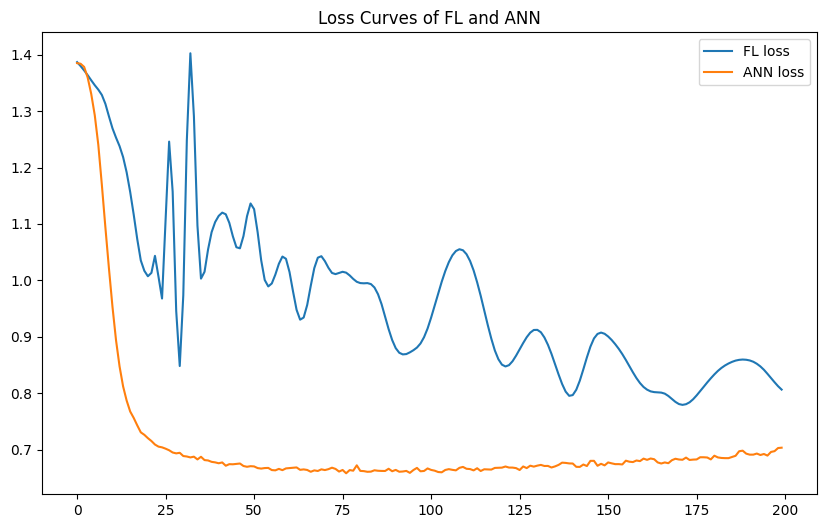

In [49]:
compare_data = pd.read_csv("test_res_FL.csv")
ANN_loss_list = compare_data['ANN_loss'].dropna().to_list()
ANN_acc_list = compare_data['ANN_acc'].dropna().to_list()

plt.figure(figsize=[10, 6])
plt.plot(range(0, 200), plot_test_loss)
plt.plot(range(0, 200), ANN_loss_list)
plt.legend(['FL loss', 'ANN loss'])
plt.title("Loss Curves of FL and ANN")
plt.show()

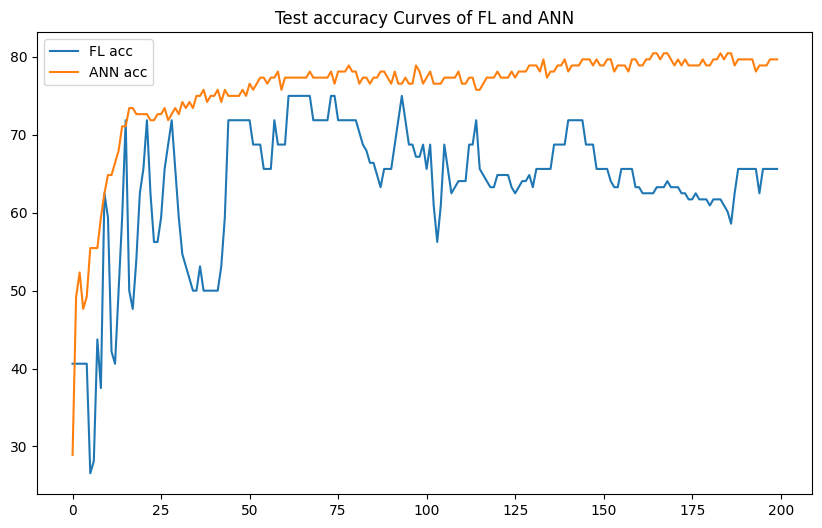

In [19]:
ann_acc = pd.read_csv("ANN_test_acc.csv")
ANN_acc_list = ann_acc['ANN'].dropna().to_list()
plt.figure(figsize=[10, 6])
plt.plot(range(0, 200), plot_test_acc)
plt.plot(range(0, 200), ANN_acc_list)
plt.legend(['FL acc', 'ANN acc'])
plt.title("Test accuracy Curves of FL and ANN")
plt.show()

In [16]:
# inference
test_data = pd.read_csv(r'D:\PyCharmProject\polyuSubject\COMP5434\test_data.csv')
x_test = test_data.values
scaler = pickle.load(open('scaler.pkl', 'rb'))
x_test = scaler.transform(x_test)
inference_net = ANN()
inference_net.load_state_dict(torch.load('best_model_3.pth'))
res = []
x_test = torch.tensor(x_test, dtype=torch.float, requires_grad=False)
for i in range(len(x_test)):
    out = inference_net(x_test[i])
    out = out.detach().numpy().tolist()
    label = out.index(max(out))
    res.append(label)
res

[3,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 3,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 3,
 3,
 1,
 3,
 0,
 0,
 0,
 3,
 0,
 1,
 1,
 1,
 3,
 1,
 0,
 1,
 1,
 3,
 1,
 0,
 3,
 3,
 0,
 0,
 0,
 3,
 3,
 1,
 3,
 3,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 0,
 3,
 1,
 0,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 3,
 1,
 1,
 3,
 3,
 3,
 3,
 1,
 0,
 3,
 0,
 3,
 1,
 3,
 3,
 0,
 1,
 1,
 3,
 1,
 3,
 1,
 3,
 0,
 3,
 1,
 3,
 1,
 1,
 0,
 1,
 3,
 3,
 1,
 1,
 3,
 3,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 3,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 3,
 1,
 1,
 0,
 3,
 0,
 1,
 1,
 1,
 1,
 0,
 3,
 3,
 1,
 3,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 3,
 3,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 3,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 3,
 0,
 1,
 3,
 1,
 3,
 1,
 1,
 3,
 1,
 3,
 3,
 0,
 1,
 3,
 0,
 3,
 1,
 1,
 1,
 0,
 0,
 1,
 3,
 3,
 1,
 0,
 1,
 3,
 1,
 3,
 3,
 1,
 3,


For bonus2, we compare the weight norm of hidden layers between iid one and non-iid FL.

In [9]:
weight_epoch

[{'model.0.weight': tensor(6.4933, grad_fn=<CopyBackwards>),
  'model.2.weight': tensor(9.3235, grad_fn=<CopyBackwards>),
  'model.5.weight': tensor(9.3430, grad_fn=<CopyBackwards>),
  'model.8.weight': tensor(6.6143, grad_fn=<CopyBackwards>),
  'model.11.weight': tensor(1.1408, grad_fn=<CopyBackwards>)},
 {'model.0.weight': tensor(6.4933, grad_fn=<CopyBackwards>),
  'model.2.weight': tensor(9.3235, grad_fn=<CopyBackwards>),
  'model.5.weight': tensor(9.3430, grad_fn=<CopyBackwards>),
  'model.8.weight': tensor(6.6143, grad_fn=<CopyBackwards>),
  'model.11.weight': tensor(1.1408, grad_fn=<CopyBackwards>)},
 {'model.0.weight': tensor(6.4933, grad_fn=<CopyBackwards>),
  'model.2.weight': tensor(9.3235, grad_fn=<CopyBackwards>),
  'model.5.weight': tensor(9.3430, grad_fn=<CopyBackwards>),
  'model.8.weight': tensor(6.6143, grad_fn=<CopyBackwards>),
  'model.11.weight': tensor(1.1408, grad_fn=<CopyBackwards>)},
 {'model.0.weight': tensor(6.4933, grad_fn=<CopyBackwards>),
  'model.2.weight'

calculate the Average Weight Local Update Delta and plot
please refer to bonus2.pdf

In [10]:
in_weight = []
h1_weight = []
h2_weight = []
h3_weight = []
out_weight = []
for epoch in range(200):
    in_weight.append(weight_epoch[epoch]['model.0.weight'].item())
    h1_weight.append(weight_epoch[epoch]['model.2.weight'].item())
    h2_weight.append(weight_epoch[epoch]['model.5.weight'].item())
    h3_weight.append(weight_epoch[epoch]['model.8.weight'].item())
    out_weight.append(weight_epoch[epoch]['model.11.weight'].item())
in_weight_delta = []
h1_weight_delta = []
h2_weight_delta = []
h3_weight_delta = []
out_weight_delta = []
for epoch in range(2, 199):
    in_weight_delta.append((in_weight[epoch+1]-in_weight[epoch])/in_weight[epoch])
    h1_weight_delta.append((h1_weight[epoch+1]-h1_weight[epoch])/h1_weight[epoch])
    h2_weight_delta.append((h2_weight[epoch+1]-h2_weight[epoch])/h2_weight[epoch])
    h3_weight_delta.append((h3_weight[epoch+1]-h3_weight[epoch])/h3_weight[epoch])
    out_weight_delta.append((out_weight[epoch+1]-out_weight[epoch])/out_weight[epoch])

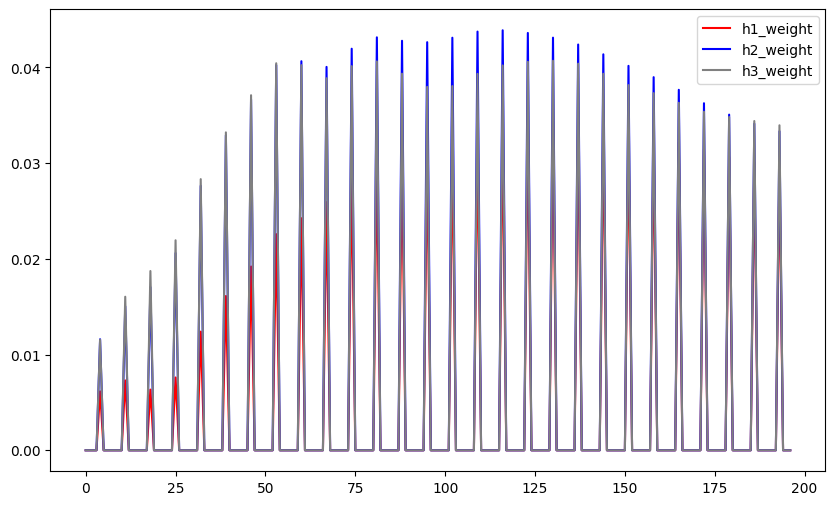

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 6])
# plt.plot(range(0, len(in_weight_delta)), in_weight_delta)
plt.plot(range(0, len(in_weight_delta)), h1_weight_delta, color='red')
plt.plot(range(0, len(in_weight_delta)), h2_weight_delta, color='blue')
plt.plot(range(0, len(in_weight_delta)), h3_weight_delta, color='gray')
# plt.plot(range(0, len(in_weight_delta)), out_weight_delta)
plt.legend(['h1_weight', 'h2_weight', 'h3_weight'])
plt.show()

In [13]:
pd.DataFrame({"h1_weight_delta":h1_weight_delta, "h2_weight_delta":h2_weight_delta, "h3_weight_delta":h3_weight_delta}).to_csv("delta_iid.csv")